# 2022-05-13 • A Network

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

In [5]:
p = get_params(duration=10*minutes);
# dumps(p)

## Run sim

In [21]:
s = cached(sim, [p.sim]);

Uncached output:
```
Running simulation: 100%|███████████████████████████████| Time: 0:05:46
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\24d9de18b7c371f6.jld2` … done (15.2 s)
```

In [17]:
import PyPlot

In [30]:
using VoltoMapSim.Plot

In [33]:
tlim = @. 3minutes + [0,10]seconds;

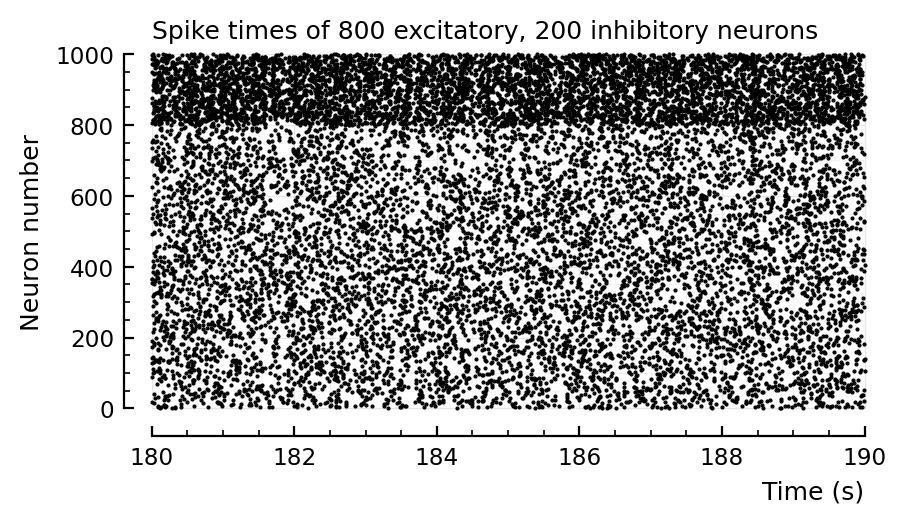

In [34]:
rasterplot(s.spike_times; tlim);

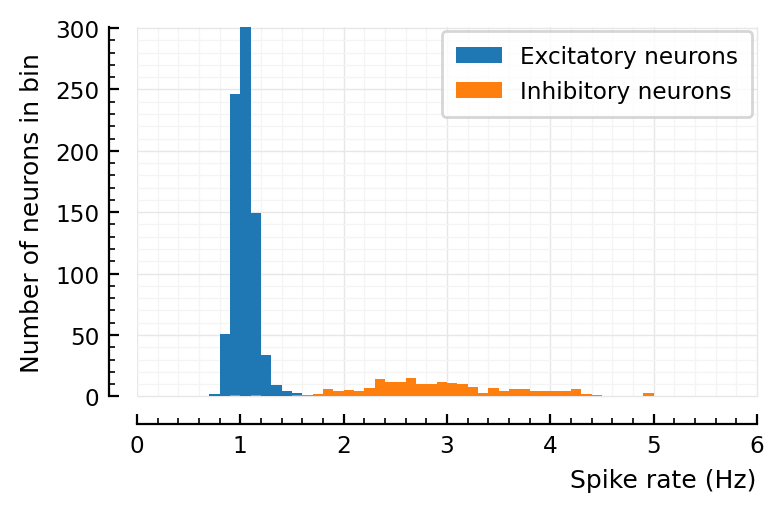

In [25]:
num_spikes = length.(s.spike_times)
spike_rates = num_spikes ./ p.sim.general.duration
fig, ax = plt.subplots()
M = round(Int, maximum(spike_rates))
bins = 0:0.1:M
xlim = (0, M)
ax.hist(spike_rates.exc; bins, label="Excitatory neurons")
ax.hist(spike_rates.inh; bins, label="Inhibitory neurons")
# ax.text(2.2, 80, "Excitatory", c=as_mpl_type(color_exc))
# ax.text(5.2, 30, "Inhibitory", c=as_mpl_type(color_inh))
ax.legend()
set(ax, xlabel="Spike rate (Hz)", ylabel="Number of neurons in bin"; xlim);

In [35]:
VI_sigs = add_VI_noise(s.voltage_traces, p);

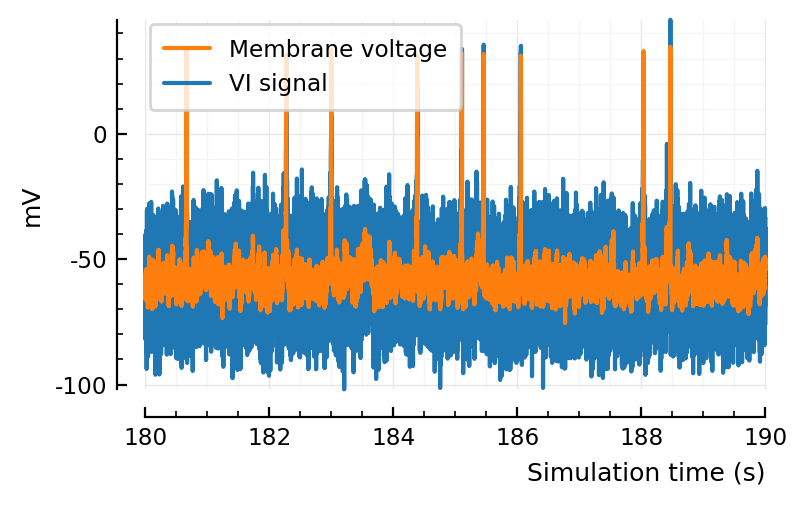

In [63]:
ax = plotsig(simdata.timesteps, VI_sigs[1] / mV; tlim, label="VI signal");
ax = plotsig(simdata.timesteps, s.voltage_traces[1] / mV; tlim, ax, label="Membrane voltage")
legend(ax, reorder=[2=>1])
set(ax, xlabel="Simulation time (s)", ylabel="mV");

## Connection test

In [73]:
trace_ID = 1
VI_sig = VI_sigs[trace_ID];

In [75]:
analyzed_neuron = s.recorded_neurons[trace_ID]  # neuron ID

469

In [102]:
input_neurons = s.input_neurons[analyzed_neuron]
length(input_neurons)

98

In [107]:
input_neurons_by_type = CVec(exc=[n for n in input_neurons if s.neuron_type[n] == :exc],
                             inh=[n for n in input_neurons if s.neuron_type[n] == :inh])

ComponentVector{Int64}(exc = [4, 11, 12, 21, 31, 71, 80, 83, 85, 93  …  729, 747, 757, 759, 769, 775, 781, 782, 786, 790], inh = [807, 808, 826, 828, 833, 839, 846, 850, 870, 879  …  906, 910, 917, 918, 932, 940, 948, 963, 992, 994])

In [109]:
length(input_neurons_by_type.exc),
length(input_neurons_by_type.inh)

(75, 23)

In [78]:
unconnected_neurons = [n for n in s.neuron_IDs if n ∉ input_neurons && n != analyzed_neuron];
length(unconnected_neurons)

901

Calc and plot STA of some excitatory inputs (first row) and inhibitory inputs (second row).

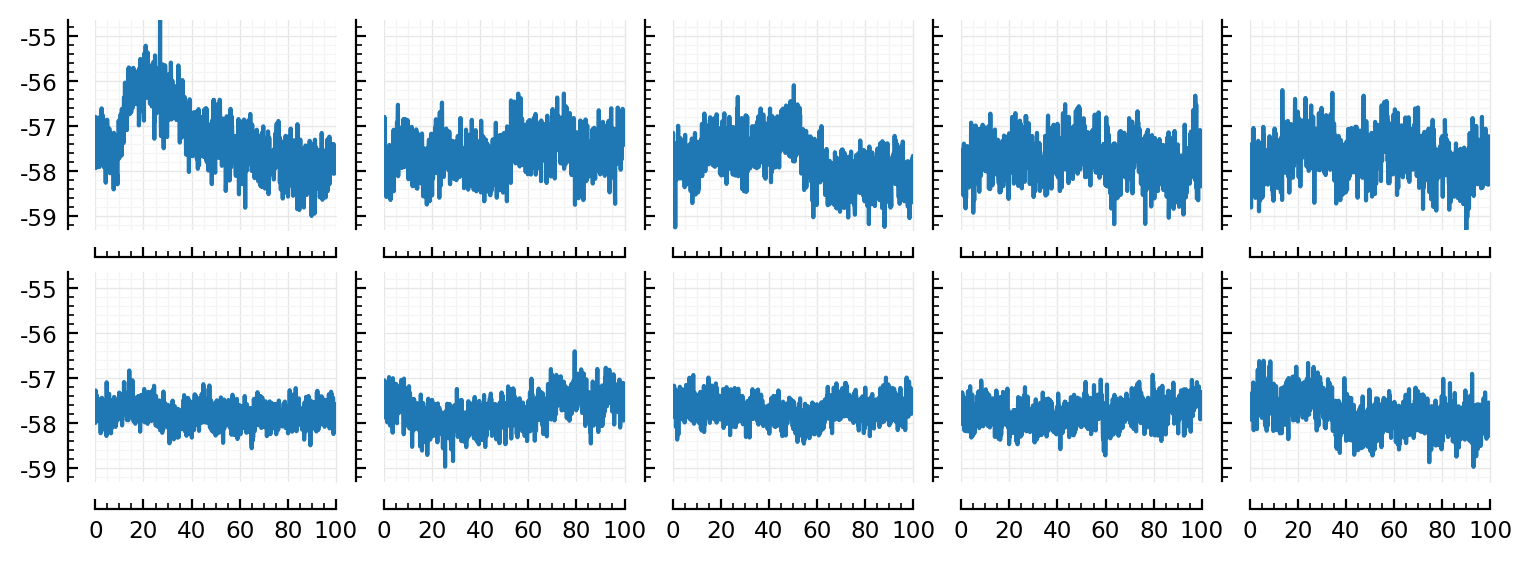

In [112]:
(nrows, ncols) = (2, 5)
fig, axs = plt.subplots(; nrows, ncols, figsize=(9, 2.2), sharex=true, sharey=true)
for r in 1:nrows
    for c in 1:ncols
        ax = axs[r, c]
        if r == 1
            n = input_neurons_by_type.exc[c]
        else
            n = input_neurons_by_type.inh[c]
        end
        plotSTA(VI_sig, s.spike_times[n], p; ax, xlabel=nothing, hylabel=nothing)
    end
end

Let's calculate and plot STA heights.

In [ ]:
calc_STA()